In [27]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 12 09:26:57 2019

@author: ypdx126
"""
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import pycard as pc


path = r'H:\Kaggle\titanic\data' + '\\'
train = pd.read_csv(path + 'train.csv')
train = train.set_index('PassengerId')
test = pd.read_csv(path + 'test.csv')
test = test.set_index('PassengerId')
y = train.Survived
y_test = pd.read_csv(path+'test_label.csv').Survived.values

def split_df(df_all):
    "拆分成train, test"
    logic = df_all.Survived.isnull()
    train = df_all[~logic]
    test = df_all[logic]
    train.drop('Survived',axis=1,inplace=True)
    test.drop('Survived',axis=1,inplace=True)
    return train, test

def concat_df(train, test):
    "合并train, test"
    df = pd.concat([train, test])
    col = ['Survived'] + list(df.columns.drop('Survived'))
    return df[col]

df_all = pd.concat([train,test])
v = y.value_counts()
v['avg'] = v[1] / v.sum()
print('train',train.shape)
print('test',test.shape)
print('Survived:')
print(v)

train (891, 11)
test (418, 10)
Survived:
0      549.000000
1      342.000000
avg      0.383838
Name: Survived, dtype: float64


## 快速决策树模型，了解特征重要性、模型baseline

In [41]:
df_all['family_num'] = df_all.Parch + df_all.SibSp
df_all['Sex_int'] = df_all.Sex.map({'male':1,'female':0})

sub = df_all[(df_all.Pclass == 3)&(df_all.Parch == 0)&(df_all.SibSp == 0)]
m = sub.Fare.mean()
df_all.Fare = df_all.Fare.fillna(m)

df_all['pclass_1'] = df_all.Pclass == 1
df_all['pclass_2'] = df_all.Pclass == 2
df_all['pclass_3'] = df_all.Pclass == 3

col = ['Pclass','Sex_int','SibSp','Parch','Fare','family_num']
trn, tst = split_df(df_all)

best_score: 0.8181818181818182
best param {'max_depth': 8, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 4}
train accuracy: 0.8507295173961841
test accuracy: 0.7799043062200957


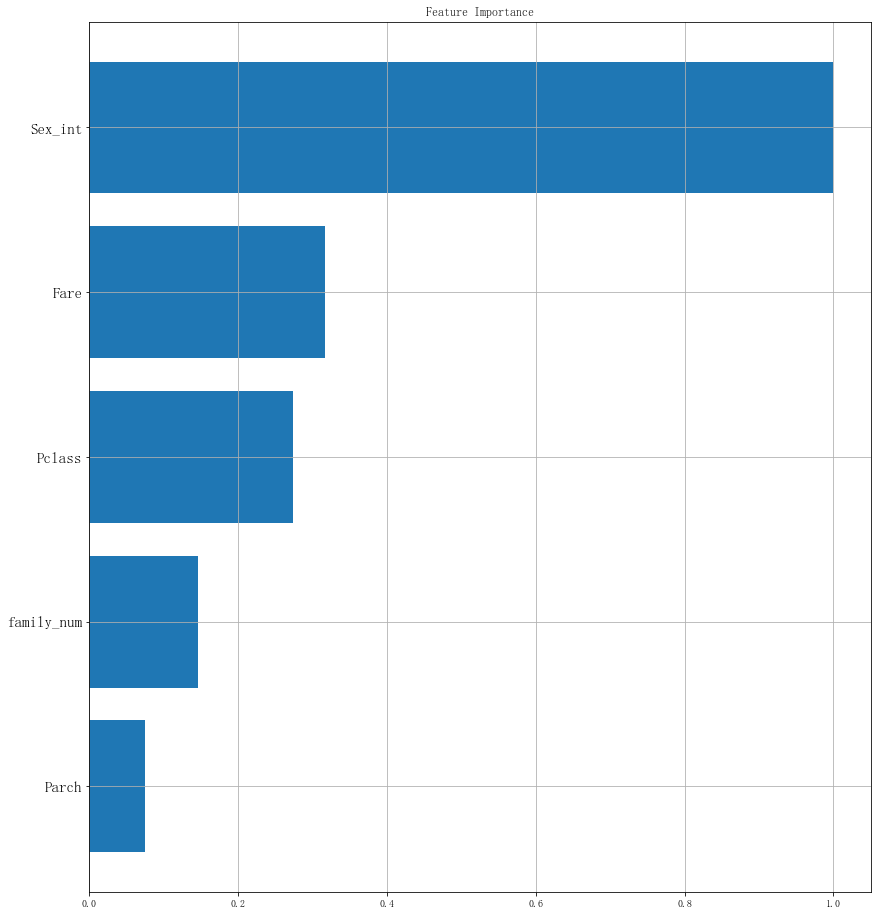

In [44]:
col = ['Pclass','Sex_int','Parch','Fare','family_num']  # 不要有完全线性相关的特征，剔除SibSp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier()
param = {'max_depth':[7,8,9,10],'min_samples_leaf':[4,5,6,7,8], 'min_impurity_decrease':np.linspace(0.0005,0.005,21)}
grid = GridSearchCV(clf, param_grid=param,n_jobs=6, cv=5, scoring='accuracy')
grid.fit(trn[col],y)
print('best_score:', grid.best_score_)
print('best param', grid.best_params_)

# 训练准确率
y_pre1 = grid.best_estimator_.predict(trn[col])
y_pre2 = grid.best_estimator_.predict(tst[col])
print('train accuracy:', (y_pre1 == y).sum()/len(y))
print('test accuracy:', (y_pre2 == y_test).sum()/len(y_test))

feature_impt = grid.best_estimator_.feature_importances_
feature_impt = pd.Series(feature_impt,index=col)
feature_impt = (feature_impt / feature_impt.max()).sort_values(ascending=False)
plt.figure(figsize=(14,16))
plt.barh(range(len(feature_impt),0,-1), feature_impt)
plt.title('Feature Importance')
plt.grid('on')
a=plt.yticks(range(len(feature_impt),0,-1),feature_impt.index, fontsize=15)

In [37]:
from sklearn.tree import export_graphviz
export_graphviz(grid.best_estimator_,out_file=r'D:\titanic.dot',
                feature_names=col,
                proportion=True,impurity=False,rounded=True,precision=4,
                node_ids=True)

![查看快速模型：决策树](https://imgchr.com/i/ZlQD4e)

# 1、缺失值处理

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64



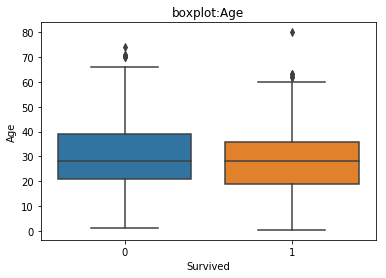

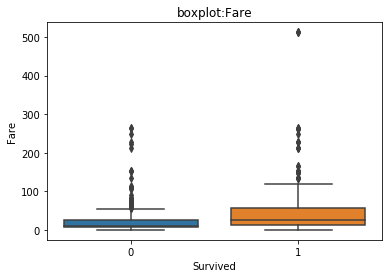

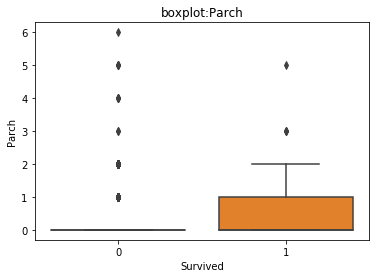

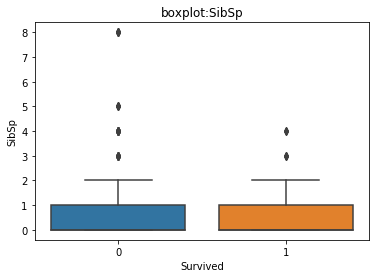

In [59]:
# 原始特征分组
num_col = ['Age', 'Fare', 'Parch', 'SibSp']
str_col = ['Cabin', 'Name','Ticket']
cat_col = ['Embarked', 'Sex']
ord_col = ['Pclass']

# 离散型变量：性别、Pclass均有较强区分度
for col in ord_col+cat_col:
    g = train.groupby(col)
    print(g.Survived.mean())
    print('')
    
# 连续型变量：有父母的、年龄低的、票价高的，存活率更高
for col in num_col:
    df = train[train[col].notnull()]
    sb.boxplot(x='Survived', y=col, data=df)
    plt.title('boxplot:{}'.format(col))
    plt.show()

##  1.1 Age

   Pclass     Sex   Age
0       1  female  36.0
1       1    male  42.0
2       2  female  28.0
3       2    male  29.5
4       3  female  22.0
5       3    male  25.0


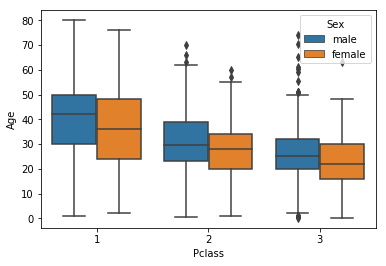

In [60]:
has_na = ['Age', 'Cabin', 'Embarked','Fare']

# 在不同的Pclass, Sex 分组中，年龄的分布显著不同
age_median = df_all.groupby(['Pclass', 'Sex']).Age.agg('median')
age_median = age_median.reset_index()
print(age_median)
sb.boxplot(x='Pclass',y='Age',data=df_all[df_all.Age.notnull()],hue='Sex')

# 用分组内的中位数填充缺失值
for idx in age_median.index:
    row_i = age_median.loc[idx,:]
    logic = (df_all.Pclass == row_i.Pclass) & (df_all.Sex == row_i.Sex) & df_all.Age.isnull()
    df_all.loc[logic, 'Age'] = row_i.Age

## 1.2 Cabin

In [61]:
def deck(Cabin):
    "解析特征：甲板层数"
    if pd.isnull(Cabin):
        return 'NA'
    else:
        c = Cabin[0]
        return c
df_all['deck'] = df_all.Cabin.map(deck)

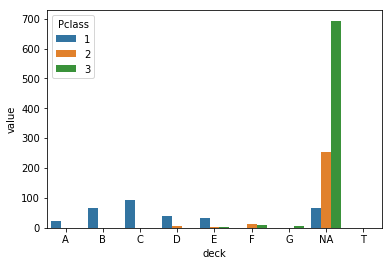

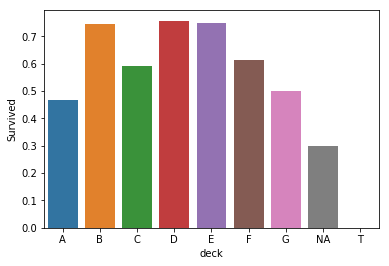

In [62]:
df = pd.crosstab(df_all.deck, df_all.Pclass).reset_index()
df = df.melt(id_vars=['deck'],value_vars=[1,2,3], var_name='Pclass')
sb.barplot(x='deck', y='value',data=df, hue='Pclass')
plt.show()

trn,tst = split_df(df_all)
rate = df_all.groupby('deck').Survived.mean().reset_index()
sb.barplot('deck','Survived',data=rate)

In [63]:
df_all['deck'] = df_all['deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['deck'] = df_all['deck'].replace(['D','E'],'DE')
df_all['deck'] = df_all['deck'].replace(['F','G'],'FG')
df_all['deck'] = df_all['deck'].replace(['T'],'A')
df_all.drop('Cabin',axis=1,inplace=True)

## 1.3 Embarked

In [72]:
df_all[df_all.Embarked.isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,deck
61,36.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,B
829,36.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,B


In [73]:
df_all.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [64]:
# S 分类占了绝大多数，因此以众数填充
df_all.Embarked = df_all.Embarked.fillna('S')

## 1.4 Fare

In [75]:
# 来自第 3 等级（Pclass), 25岁，
df_all[df_all.Fare.isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,deck
152,25.0,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,NA


In [76]:
# 这是独自乘船的客户，不与他人共用船票,无法通过Ticket获知票价
df_all[df_all.Ticket=='3701']

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,deck
152,25.0,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,NA


In [65]:
# 以第 3 等级（Pclass),独自出行的分组平均票价，来填充缺失值
sub = df_all[(df_all.Pclass == 3)&(df_all.Parch == 0)&(df_all.SibSp == 0)]
m = sub.Fare.mean()
df_all.Fare = df_all.Fare.fillna(m)
print(sub.shape)
sub.head(10)

(472, 11)


,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,deck
PassengerId,,,,,,,,,,,
3,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,NA
5,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,NA
6,25.0,Q,8.4583,"Moran, Mr. James",0,3,male,0,0.0,330877,NA
13,20.0,S,8.0500,"Saundercock, Mr. William Henry",0,3,male,0,0.0,A/5. 2151,NA
15,14.0,S,7.8542,"Vestrom, Miss. Hulda Amanda Adolfina",0,3,female,0,0.0,350406,NA
20,22.0,C,7.2250,"Masselmani, Mrs. Fatima",0,3,female,0,1.0,2649,NA
23,15.0,Q,8.0292,"McGowan, Miss. Anna ""Annie""",0,3,female,0,1.0,330923,NA
27,25.0,C,7.2250,"Emir, Mr. Farred Chehab",0,3,male,0,0.0,2631,NA
29,22.0,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,3,female,0,1.0,330959,NA


In [66]:
df_no_na = df_all.copy()  # 里程碑备份，后面操作错误需要回滚时，可以从这里开始
len(df_no_na) - df_no_na.count()

Age           0
Embarked      0
Fare          0
Name          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
Ticket        0
deck          0
dtype: int64

#  2 特征提取

In [67]:
# 新的特征分组
num_col = ['Age', 'Fare', 'Parch', 'SibSp']
str_col = ['Name','Ticket']
cat_col = ['Embarked', 'Sex', 'deck']
ord_col = ['Pclass']
df_all.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'deck'],
      dtype='object')

## 2.1 亲人数量

In [78]:
df_all['family_num'] = df_all['Parch'] + df_all['SibSp'] + 1
family_map = lambda x: '1' if x== 1 else '2-4' if x < 4 else '5-6' if x < 7 else '7+'
df_all['family_num_Grouped'] = df_all['family_num'].map(family_map)
pc.cross_woe(df_all.family_num_Grouped,df_all.Survived)

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini
family_num_Grouped,,,,,,,,,,
1,family_num_Grouped,374,163,537,0.602694,0.303538,0.357218,0.073098,0.267402,0.255654
2-4,family_num_Grouped,115,148,263,0.295174,0.562738,-0.725568,0.162002,0.267402,0.255654
5-6,family_num_Grouped,39,27,66,0.074074,0.409091,-0.105563,0.000835,0.267402,0.255654
7+,family_num_Grouped,21,4,25,0.028058,0.160000,1.184940,0.031467,0.267402,0.255654


## 2.2 从 Ticket 中提取特征

In [14]:
df_all.Ticket.value_counts()
df_all[df_all.Ticket.isin(['1601','CA. 2343','CA 2144','3101295'])].sort_values('Ticket')
# 此数据中看出：1、共用同一Ticket的，票价相同，因此可以计算平均票价； 
# 2、共用同一Ticket的，可以看作同一个组，这种组可能是朋友团、也可能是家人

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,deck,family_num,is_alone
39,25.0,S,56.4958,"Hee, Mr. Ling",0,931,3,male,0,NaN,1601,NA,1,True
838,25.0,S,56.4958,"Chip, Mr. Chang",0,839,3,male,0,1.0,1601,NA,1,True
74,25.0,S,56.4958,"Bing, Mr. Lee",0,75,3,male,0,1.0,1601,NA,1,True
826,25.0,S,56.4958,"Lam, Mr. Len",0,827,3,male,0,0.0,1601,NA,1,True
169,25.0,S,56.4958,"Ling, Mr. Lee",0,170,3,male,0,0.0,1601,NA,1,True
692,25.0,S,56.4958,"Lam, Mr. Ali",0,693,3,male,0,1.0,1601,NA,1,True
643,25.0,S,56.4958,"Foo, Mr. Choong",0,644,3,male,0,1.0,1601,NA,1,True
509,25.0,S,56.4958,"Lang, Mr. Fang",0,510,3,male,0,1.0,1601,NA,1,True
50,25.0,S,39.6875,"Panula, Master. Juha Niilo",1,51,3,male,4,0.0,3101295,NA,6,False
824,25.0,S,39.6875,"Panula, Master. Urho Abraham",1,825,3,male,4,0.0,3101295,NA,6,False


In [79]:
# 共用同一Ticket的，可以看作同一个组
group = df_all.Ticket.value_counts()
df_all['group_num'] = df_all.Ticket.map(group)
df_all['avg_fare'] = df_all['Fare'] / df_all['group_num']

In [80]:
df_all[['family_num','group_num','Fare','avg_fare']].corr() # 两组变量之间确实存在较大相关性，但也表明有额外的信息

,family_num,group_num,Fare,avg_fare
family_num,1.000000,0.800556,0.226646,-0.050062
group_num,0.800556,1.000000,0.479052,0.094246
Fare,0.226646,0.479052,1.000000,0.819894
avg_fare,-0.050062,0.094246,0.819894,1.000000


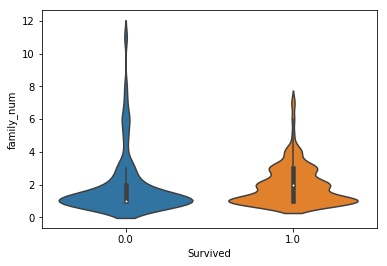

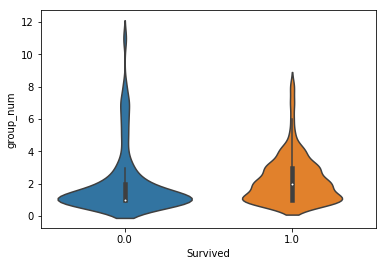

In [92]:
sb.violinplot(y='family_num',x='Survived',data=df_all[df_all.Survived.notnull()])
plt.show()
sb.violinplot(y='group_num',x='Survived',data=df_all[df_all.Survived.notnull()])
plt.show()
# 1、两个变量都有一些极值，
# 2、当组员多于2个时，存活率明显增加

In [92]:
# 计算同一Ticket组的存活率
trn,tst = split_df(df_all)
ticket_set = set(trn.Ticket) & set(tst.Ticket)

tck_rate = df_all.groupby('Ticket').Survived.agg(['mean','count']) # test中Survived全为空，所以并没有用test
tck_rate = tck_rate[tck_rate['count'] > 1]['mean']
tck_rate = tck_rate[tck_rate.index.isin(ticket_set)]

df_all['ticket_rate_na'] = df_all.Ticket.map(lambda x: 1 if x in ticket_rate else 0)
df_all['ticket_rate'] = df_all.Ticket.map(lambda x: family_rate.get(x, family_rate_mean))

In [93]:
df_all.drop(['Ticket'],axis=1,inplace=True)

##  2.3 从 Name 中提取特征

In [84]:
def name_proc(name):
    "从名称中提取出头衔"
    tmp = name.split(',')[1]
    title = tmp.split('.')[0].strip()
    return title
df_all['title'] = df_all.Name.map(name_proc)

In [85]:
df_all['title'] = df_all.title.replace(['Ms','Lady','Mlle'],'Miss')
df_all['title'] = df_all.title.replace(['Mme'],'Mrs')
logic =  ~df_all.title.isin(['Mr','Miss','Mrs','Master'])
df_all.loc[logic,'title'] = 'Other'

In [86]:
a = pd.crosstab(df_all.title, df_all.Survived)
a['all'] = a[0]+a[1]
a['rate'] = a[1]/a['all']
a.sort_values('all',ascending=False)

Survived,0.0,1.0,all,rate
title,,,,
Mr,436,81,517,0.156673
Miss,55,131,186,0.704301
Mrs,26,100,126,0.793651
Master,17,23,40,0.575000
Other,15,7,22,0.318182


In [87]:
import string
def extract_surname(name):    
    "提取姓氏， 以相同姓氏为一个家庭"
    if '(' in name:
        name_no_bracket = name.split('(')[0] 
    else:
        name_no_bracket = name

    family = name_no_bracket.split(',')[0]
    for c in string.punctuation:
        family = family.replace(c, '').strip()
    return family
df_all['Family'] = df_all['Name'].map(extract_surname)

In [90]:
# 以同一姓氏为一组，计算存活率。
fml_rate = df_all.groupby('Family').Survived.agg(['mean','count'])
fml_rate = fml_rate[fml_rate['count'] > 1]['mean']

trn,tst = split_df(df_all)
family_set = set(trn.Family) & set(tst.Family)
fml_rate = fml_rate[fml_rate.index.isin(family_set)]

df_all['Family_rate_na'] = df_all['Family'].map(lambda x: 1 if x in family_rate else 0)
df_all['Family_rate'] = df_all.Family.map(lambda x: fml_rate.get(x,0.383838))

In [124]:
df_all['Survival_Rate'] = (df_all['Family_rate'] + df_all['ticket_rate']) / 2
df_all['Survival_Rate_NA'] = (df_all['Family_rate_na'] + df_all['ticket_rate_na']) / 2    

In [97]:
df_all.drop(['Name','Family'],axis=1,inplace=True)

In [99]:
df_feature = df_all.copy()  # 里程碑备份
ts.pkl_dump(df_feature,path+'df_feature.pkl')

# 3 特征转换

In [100]:
# 新的特征列表
num_col = ['Age', 'Fare', 'avg_fare', 'Parch', 'SibSp', 'group_num',
          'Family_rate', 'Ticket_rate' ]
bol_col = [ 'Family_rate_na', 'Ticket_rate_na']
cat_col = ['Embarked', 'Sex', 'deck', 'title','family_num_Grouped']
ord_col = ['Pclass']
df_all.columns

Index(['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'deck', 'family_num', 'family_num_Grouped', 'group_num',
       'avg_fare', 'ticket_rate_na', 'ticket_rate', 'title', 'Family_rate_na',
       'Family_rate', 'Survival_Rate', 'Survival_Rate_NA'],
      dtype='object')

## 3.1 数值型变量分箱

### Age

In [130]:
clf = pc.NumBin(max_depth=4, min_samples_leaf=50, max_leaf_nodes=10)
trn, tst = split_df(df_all)
clf.fit(trn.Age,y)
clf.bins_

[7.5, 18.5, 21.5, 24.25, 26.5, 34.25, 36.25, 41.5, 47.5]

In [144]:
df_all['age_7.5-'] = df_all.Age <=7.5
df_all['age_26.5~34.25'] = (df_all.Age > 26.5) & (df_all.Age <= 34.25)
df_all['age_34.25~36.25'] = (df_all.Age > 34.25) & (df_all.Age <= 36.25)

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini,num,female_rate
row_0,,,,,,,,,,,,
1_7.5-,var,16,34,50,0.056117,0.680000,-1.227060,0.086227,0.388641,0.323709,1,0.469697
2_7.5~18.5,var,53,36,89,0.099888,0.404494,-0.086515,0.000755,0.388641,0.323709,2,0.480315
3_18.5~21.5,var,48,17,65,0.072952,0.261538,0.564700,0.021303,0.388641,0.323709,3,0.278351
4_21.5~24.25,var,59,56,115,0.129068,0.486957,-0.421102,0.023697,0.388641,0.323709,4,0.642857
5_24.25~26.5,var,115,21,136,0.152637,0.154412,1.227122,0.181698,0.388641,0.323709,5,0.071770
6_26.5~34.25,var,100,70,170,0.190797,0.411765,-0.116613,0.002627,0.388641,0.323709,6,0.326446
7_34.25~36.25,var,19,31,50,0.056117,0.620000,-0.962836,0.053952,0.388641,0.323709,7,0.507463
8_36.25~41.5,var,34,19,53,0.059484,0.358491,0.108634,0.000693,0.388641,0.323709,8,0.358974
9_41.5~47.5,var,53,21,74,0.083053,0.283784,0.452482,0.015898,0.388641,0.323709,9,0.240741


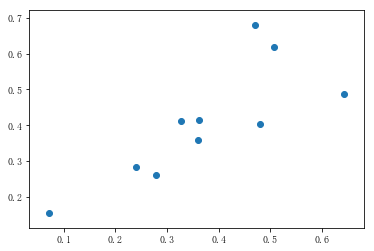

In [142]:
a = pd.crosstab(age_bin,df_all.Sex)
a['mean'] = a['female'] / a.sum(axis=1)
b['female_rate'] = a['mean']
plt.scatter(b['female_rate'],b['badRate'])
b

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini,num
row_0,,,,,,,,,,,
1_7.5-,var,16,34,50,0.056117,0.680000,-1.227060,0.086227,0.388641,0.323709,1
2_7.5~18.5,var,53,36,89,0.099888,0.404494,-0.086515,0.000755,0.388641,0.323709,2
3_18.5~21.5,var,48,17,65,0.072952,0.261538,0.564700,0.021303,0.388641,0.323709,3
4_21.5~24.25,var,59,56,115,0.129068,0.486957,-0.421102,0.023697,0.388641,0.323709,4
5_24.25~26.5,var,115,21,136,0.152637,0.154412,1.227122,0.181698,0.388641,0.323709,5
6_26.5~34.25,var,100,70,170,0.190797,0.411765,-0.116613,0.002627,0.388641,0.323709,6
7_34.25~36.25,var,19,31,50,0.056117,0.620000,-0.962836,0.053952,0.388641,0.323709,7
8_36.25~41.5,var,34,19,53,0.059484,0.358491,0.108634,0.000693,0.388641,0.323709,8
9_41.5~47.5,var,53,21,74,0.083053,0.283784,0.452482,0.015898,0.388641,0.323709,9


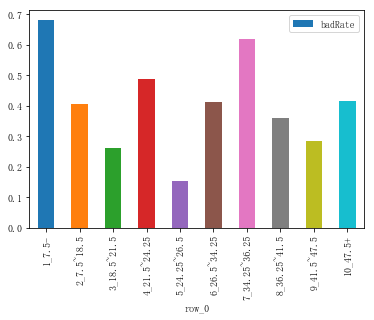

In [134]:
a = clf.transform(trn.Age)
b = pc.cross_woe(a,y)
b['num'] = b.index.map(lambda x:int(x.split('_')[0]))
b = b.sort_values('num')

age_bin = clf.transform(df_all.Age)
f = np.vectorize(lambda x:int(x.split('_')[0]),otypes=['int32'])
df_all['age_int'] = f(age_bin)

b.reset_index().plot.bar('row_0','badRate')
b

### Fare

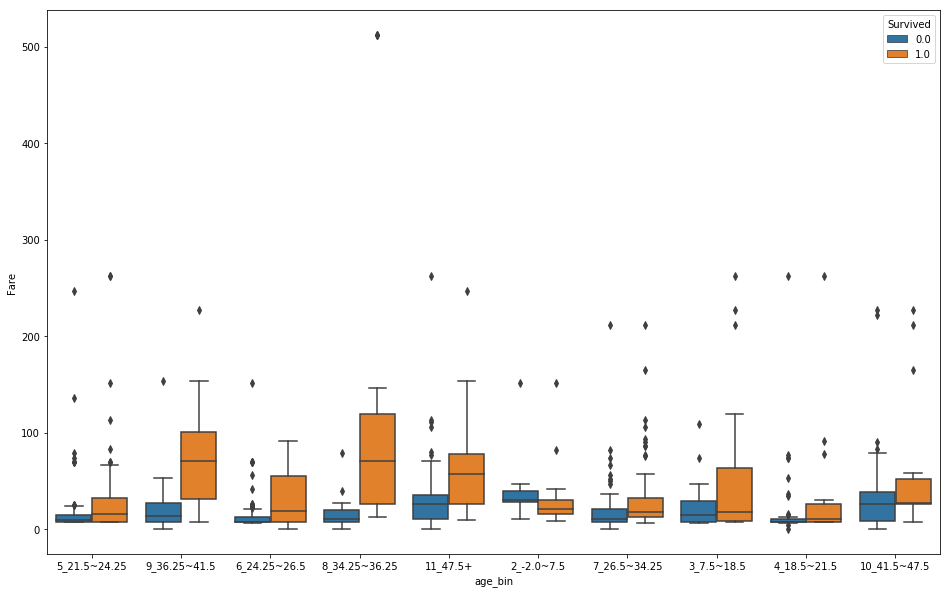

In [64]:
trn,tst = split_df(df_all)
plt.figure(figsize=(16,10))
sb.boxplot('age_bin', 'Fare',data=trn,hue='Survived')

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini,num
row_0,,,,,,,,,,,
2_-2.0~7.7312,var,85,14,99,0.111111,0.141414,1.330306,0.151510,0.728157,0.445227,2
3_7.7312~7.8833,var,56,29,85,0.095398,0.341176,0.184768,0.003180,0.728157,0.445227,3
4_7.8833~8.0396,var,48,10,58,0.065095,0.172414,1.095328,0.063739,0.728157,0.445227,4
5_8.0396~10.4812,var,83,14,97,0.108866,0.144330,1.306496,0.144039,0.728157,0.445227,5
6_10.4812~15.6459,var,83,53,136,0.152637,0.389706,-0.024739,0.000094,0.728157,0.445227,6
7_15.6459~31.1375,var,101,93,194,0.217733,0.479381,-0.390767,0.034371,0.728157,0.445227,7
8_31.1375~50.9875,var,43,20,63,0.070707,0.317460,0.292180,0.005798,0.728157,0.445227,8
9_50.9875~74.375,var,27,35,62,0.069585,0.564516,-0.732799,0.038955,0.728157,0.445227,9
10_74.375+,var,23,74,97,0.108866,0.762887,-1.641859,0.286471,0.728157,0.445227,10


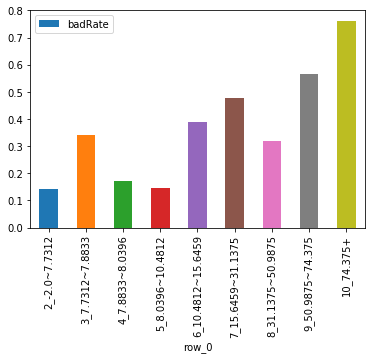

In [65]:
clf = pc.NumBin(max_depth=4, min_samples_leaf=50, max_leaf_nodes=10)
clf.fit(trn.Fare,y)
a = clf.transform(trn.Fare)
b = pc.cross_woe(a,y)
b['num'] = b.index.map(lambda x:int(x.split('_')[0]))
b = b.sort_values('num')

df_all['fare_bin'] = clf.transform(df_all.Fare)
df_all['fare_int'] = df_all['fare_bin'].map(lambda x:int(x.split('_')[0]))

b.reset_index().plot.bar('row_0','badRate')
b

### avg_fare

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini,num
row_0,,,,,,,,,,,
2_-2.0~4.8438,var,37,13,50,0.056117,0.260000,0.572681,0.016827,0.589613,0.415673,2
3_4.8438~6.2864,var,33,20,53,0.059484,0.377358,0.027488,0.000045,0.589613,0.415673,3
4_6.2864~7.3271,var,91,24,115,0.129068,0.208696,0.859518,0.082153,0.589613,0.415673,4
5_7.3271~7.8833,var,76,42,118,0.132435,0.355932,0.119776,0.001872,0.589613,0.415673,5
6_7.8833~8.6583,var,110,21,131,0.147026,0.160305,1.182670,0.164345,0.589613,0.415673,6
7_8.6583~9.5437,var,38,15,53,0.059484,0.283019,0.456248,0.011569,0.589613,0.415673,7
8_9.5437~22.2875,var,92,73,165,0.185185,0.442424,-0.241959,0.011099,0.589613,0.415673,8
9_22.2875~26.725,var,23,39,62,0.069585,0.629032,-1.001355,0.072238,0.589613,0.415673,9
10_26.725~30.5438,var,13,38,51,0.057239,0.745098,-1.545925,0.135163,0.589613,0.415673,10


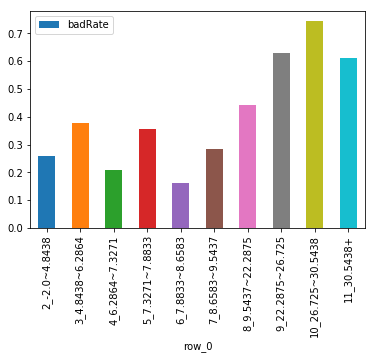

In [67]:
col = 'avg_fare'
clf = pc.NumBin(max_depth=4, min_samples_leaf=50, max_leaf_nodes=10)
clf.fit(trn[col],y)
a = clf.transform(trn[col])
b = pc.cross_woe(a,y)
b['num'] = b.index.map(lambda x:int(x.split('_')[0]))
b = b.sort_values('num')

df_all['avg_fare_bin'] = clf.transform(df_all.Fare)
df_all['avg_fare_int'] = df_all['avg_fare_bin'].map(lambda x:int(x.split('_')[0]))

b.reset_index().plot.bar('row_0','badRate')
b

### family_num, group_num, family_size

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini,num
row_0,,,,,,,,,,,
2_-2.0~1.5,var,374,163,537,0.602694,0.303538,0.357218,0.073098,0.368748,0.301835,2
3_1.5~2.5,var,72,89,161,0.180696,0.552795,-0.685258,0.088457,0.368748,0.301835,3
4_2.5~4.5,var,51,80,131,0.147026,0.610687,-0.923489,0.130232,0.368748,0.301835,4
5_4.5+,var,52,10,62,0.069585,0.161290,1.175371,0.076961,0.368748,0.301835,5


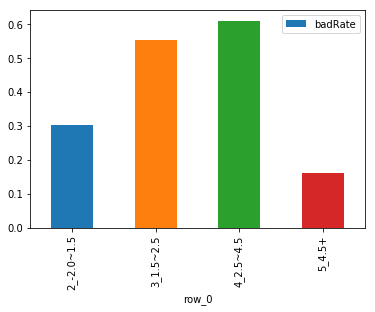

In [129]:
col = 'family_num'
clf = pc.NumBin(max_depth=4, min_samples_leaf=50, max_leaf_nodes=10)
clf.fit(trn[col],y)
a = clf.transform(trn[col])
b = pc.cross_woe(a,y)
b['num'] = b.index.map(lambda x:int(x.split('_')[0]))
b = b.sort_values('num')

df_all['family_num_bin'] = clf.transform(df_all.Fare)
df_all['family_num_int'] = df_all['family_num_bin'].map(lambda x:int(x.split('_')[0]))

b.reset_index().plot.bar('row_0','badRate')
b

Survived,colName,0,1,All,binPct,badRate,woe,IV_i,IV,Gini,num
row_0,,,,,,,,,,,
2_-2.0~1.5,var,351,130,481,0.539843,0.270270,0.519964,0.134789,0.469913,0.339591,2
3_1.5~2.5,var,88,93,181,0.203143,0.513812,-0.528550,0.059007,0.469913,0.339591,3
4_2.5~4.5,var,47,98,145,0.162738,0.675862,-1.208108,0.242757,0.469913,0.339591,4
5_4.5+,var,63,21,84,0.094276,0.250000,0.625325,0.033361,0.469913,0.339591,5


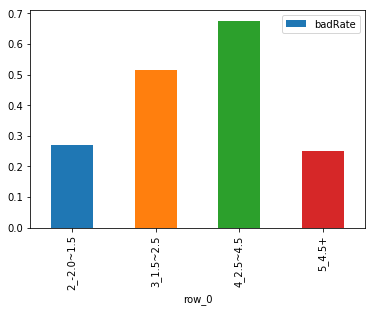

In [131]:
col = 'group_num'
clf = pc.NumBin(max_depth=4, min_samples_leaf=50, max_leaf_nodes=10)
clf.fit(trn[col],y)
a = clf.transform(trn[col])
b = pc.cross_woe(a,y)
b['num'] = b.index.map(lambda x:int(x.split('_')[0]))
b = b.sort_values('num')

df_all['group_num_bin'] = clf.transform(df_all.Fare)
df_all['group_num_int'] = df_all['group_num_bin'].map(lambda x:int(x.split('_')[0]))

b.reset_index().plot.bar('row_0','badRate')
b

### 相关性

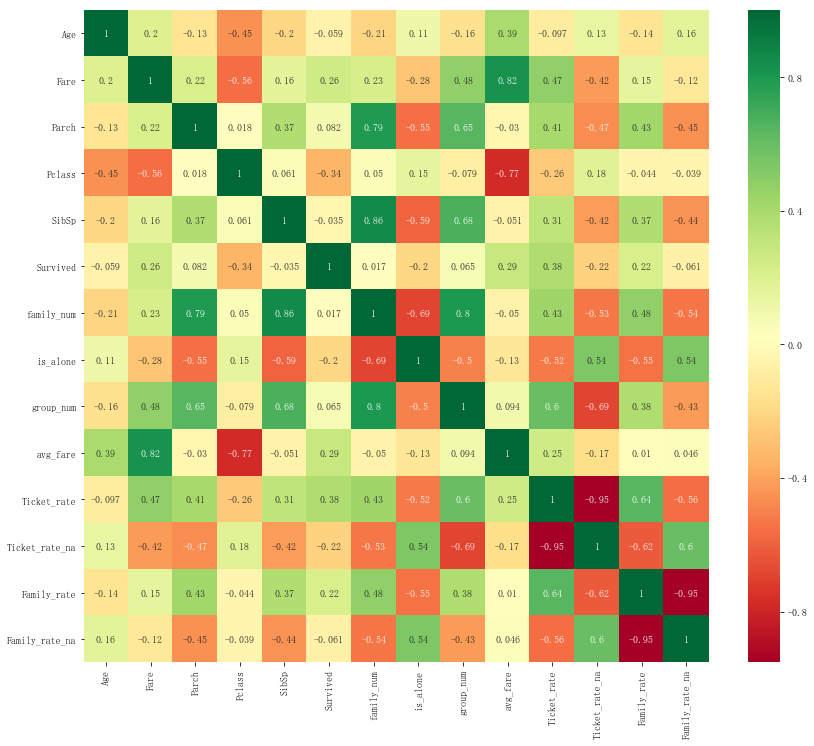

In [123]:
plt.figure(figsize=(14,12))
sb.heatmap(df_all.corr(),cmap='RdYlGn',annot=True)

## 3.2 类别型变量转换onehot

In [101]:
df_all['Sex'] =df_all['Sex'].map({'male':1, 'female':0})

In [18]:
def cate2onehot(cate_df, cols=None):
    """把类别型变量的类别值，转换成独热编码.\n
    参数:
    ----------
    cate_df: dataframe, 包含了类别型变量的明细数据框 \n
    cols: array-like, 类别型变量名组成的列表，None 表示 df_cate 中所有列都是类别型变量，需要映射。\n
    返回值：
    ----------
    df_onehot: dataframe, onehot数据框  \n"""
    
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    if cols is None: cols = cate_df.columns
    
    La = LabelEncoder()
    cates_type = []
    df_int = pd.DataFrame(index=cate_df.index)
    for col in cols:
        sr_i = cate_df[col]
        ar_i = La.fit_transform(sr_i)
        df_int[col + '_int'] = ar_i  # 映射变量
        cates_type.extend([col + '_' + str(i) for i in La.classes_])  # 记录类别到数字的映射
        
    enc = OneHotEncoder(sparse=False)
    df_onehot = pd.DataFrame(enc.fit_transform(df_int),
                             columns=cates_type, index=df_int.index)
    return df_onehot

In [102]:
cat_features = ['Pclass', 'deck', 'Embarked', 'title', 'family_num_Grouped']
df_onehot = cate2onehot(df_all[cat_features])
df_all = pd.concat([df_all, df_onehot], axis=1)

In [7]:
#pc.tools.pkl_dump(df_all, path+'df_all_clean.pkl')
df_all = pc.tools.pkl_load(path + 'df_all_clean.pkl')
trn, tst = split_df(df_all)

# 4、训练模型

In [5]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

## Random Forest

In [8]:
rf = RandomForestClassifier(criterion='gini', 
                           n_estimators=1100,
                           max_depth=5,
                           min_samples_split=4,
                           min_samples_leaf=5,
                           max_features='auto',
                           random_state=42,
                           n_jobs=-1)

In [9]:
# 最终所选的入模变量
num_col = ['Age', 'Fare', 'avg_fare','group_num', 'Family_rate', 'ticket_rate','Survival_Rate', 'Survival_Rate_NA',
           'Parch', 'SibSp', 'Sex']
bol_col = ['Family_rate_na', 'ticket_rate_na']
hot_col = ['Pclass_1','Pclass_2', 'Pclass_3',
           'Embarked_C', 'Embarked_Q', 'Embarked_S', 
           'deck_ABC', 'deck_DE', 'deck_FG', 'deck_NA', 
          'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Other',
          'family_num_Grouped_1', 'family_num_Grouped_2-4','family_num_Grouped_5-6', 'family_num_Grouped_7+']
col = num_col+bol_col+hot_col

In [12]:
trn, tst = split_df(df_all)

rf.fit(trn[col], y)

# 训练准确率
y_pre1 = rf.predict(trn[col])
y_pre2 = rf.predict(tst[col])
print('train accuracy:', (y_pre1 == y).sum()/len(y))
print('test accuracy:', (y_pre2 == y_test).sum()/len(y_test))

train accuracy: 0.8552188552188552
test accuracy: 0.7990430622009569


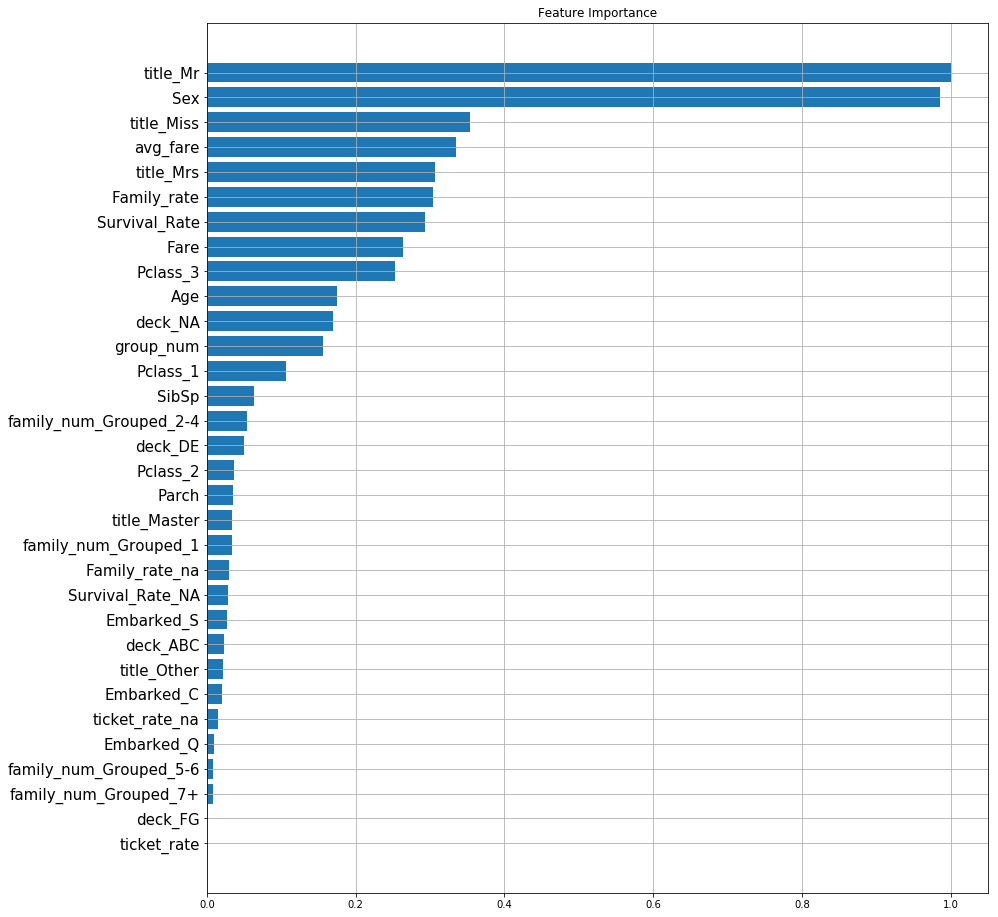

In [150]:
feature_impt = rf.feature_importances_
feature_impt = pd.Series(feature_impt,index=col)
feature_impt = (feature_impt / feature_impt.max()).sort_values(ascending=False)
plt.figure(figsize=(14,16))
plt.barh(range(len(feature_impt),0,-1), feature_impt)
plt.title('Feature Importance')
plt.grid('on')
a=plt.yticks(range(len(feature_impt),0,-1),feature_impt.index, fontsize=15)

### 并行计算, 寻找最优参数

In [27]:
# 并行计算，寻找最优参数
import joblib 
param = {'n_estimators':list(),
        'max_depth': [4,5,6]}
def fitt(n_estimators, max_depth):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    rf.fit(trn[col], y)
    y_pre2 = rf.predict(tst[col])
    test_accuracy = (y_pre2 == y_test).sum()/len(y_test)
    return [n_estimators,max_depth, test_accuracy,rf]
result = joblib.Parallel(n_jobs=4)(joblib.delayed(fitt)(n_est, depth) for n_est in range(300,500,10) for depth in [3,4,5])
df = pd.DataFrame(result, columns=['n_estimators', 'max_depth', 'test_accuracy','clf'])
df.sort_values('test_accuracy', ascending=False).head(10)

,n_estimators,max_depth,test_accuracy,clf
55,480,4,0.808612,"(DecisionTreeClassifier(class_weight=None, cri..."
37,420,4,0.806220,"(DecisionTreeClassifier(class_weight=None, cri..."
40,430,4,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
41,430,5,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
58,490,4,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
1,300,4,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
26,380,5,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
52,470,4,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
22,370,4,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."
47,450,5,0.803828,"(DecisionTreeClassifier(class_weight=None, cri..."


In [29]:
best_rf_clf = df.loc[55,'clf']
y_pre2 = best_rf_clf.predict(tst[col])

In [33]:
pc.pkl_dump(best_rf_clf, path+'best_rf_clf.pkl')

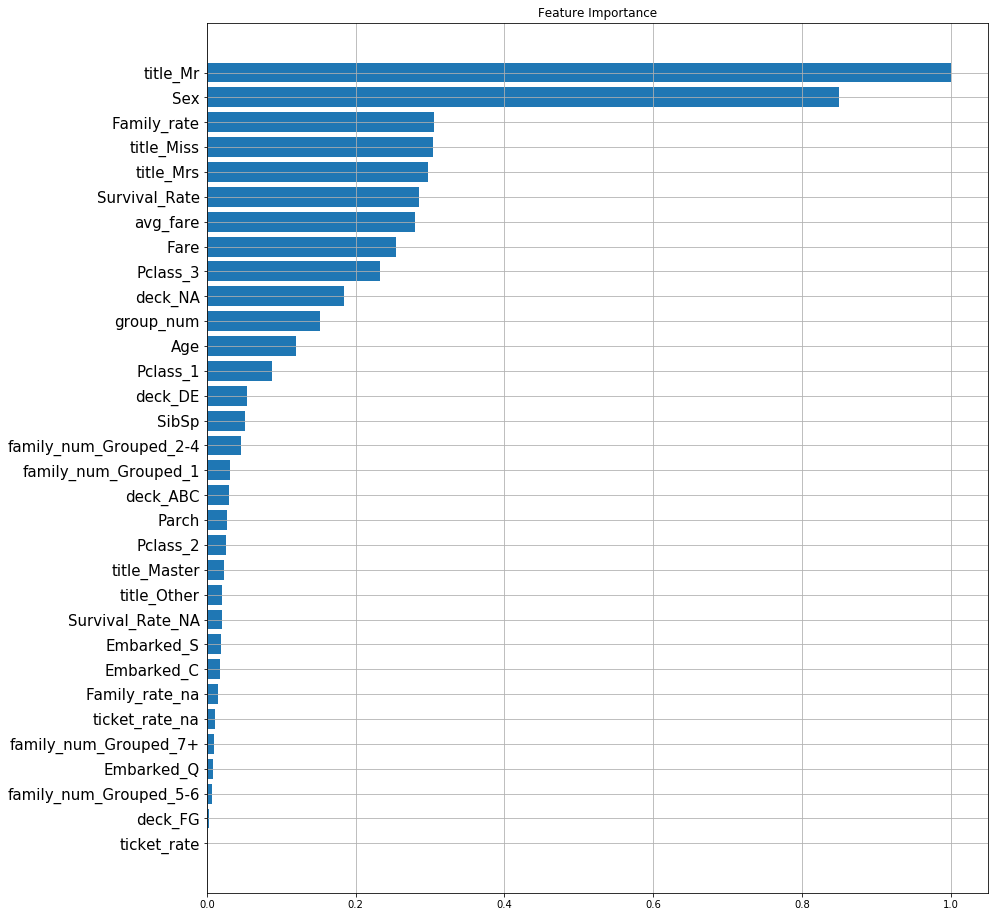

In [32]:
feature_impt = best_rf_clf.feature_importances_
feature_impt = pd.Series(feature_impt,index=col)
feature_impt = (feature_impt / feature_impt.max()).sort_values(ascending=False)
plt.figure(figsize=(14,16))
plt.barh(range(len(feature_impt),0,-1), feature_impt)
plt.title('Feature Importance')
plt.grid('on')
a=plt.yticks(range(len(feature_impt),0,-1),feature_impt.index, fontsize=15)

In [31]:
submission_gbdt28 = pd.DataFrame({'PassengerId': test.index.values,
                                 'Survived': y_pre2})
submission_gbdt28.to_csv(path + '{}.csv'.format('submission_rf808'),index=False)